In [ ]:
import os
import cv2
import math
import joblib
import numpy as np
import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import train_test_split

import tensorflow as tf
from tensorflow.keras import optimizers
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Flatten, Dense, Dropout, GlobalAveragePooling2D
from tensorflow.keras.callbacks import Callback, EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.densenet import DenseNet121
from tensorflow.keras.utils import plot_model

2024-04-03 10:27:19.464349: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-04-03 10:27:19.464435: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-04-03 10:27:19.595844: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [ ]:
# Set data path and top emotions
DATA_PATH = "/kaggle/input/fyp-dataset/AffectNet/"
TOP_EMOTIONS = ["anger", "contempt", "disgust", "fear", "happy", "neutral", "sad", "surprise"]

# Define constants
TRAIN_SIZE = 0.80
INPUT_SHAPE = (32,32,3)
NUM_CLASSES = len(TOP_EMOTIONS)
BATCH_SIZE = 64
EPOCHS = 100

In [ ]:
# Load data
total_images = 0
for dir_ in os.listdir(DATA_PATH):
    if dir_ in TOP_EMOTIONS:
        count = 0
        for f in os.listdir(DATA_PATH + dir_ + "/"):
            count += 1
        print(f"{dir_} has {count} number of images")
        total_images += count

print(f"\ntotal images are {total_images}")

surprise has 1851 number of images
fear has 1839 number of images
neutral has 1880 number of images
sad has 1821 number of images
disgust has 1740 number of images
contempt has 1833 number of images
happy has 1862 number of images
anger has 1822 number of images

total images are 14648


In [ ]:
img_arr = []
img_label = []
label_to_text = {}
label = 0

for dir_ in os.listdir(DATA_PATH):
    if dir_ in TOP_EMOTIONS:
        for f in os.listdir(DATA_PATH + dir_ + "/"):
            img = cv2.imread(DATA_PATH + dir_ + "/" + f)
            img = cv2.resize(img, (32, 32))

            # Convert image to RGB format if it's grayscale
            if img.shape[-1] == 1:
                img = cv2.cvtColor(img, cv2.COLOR_GRAY2RGB)

            img_arr.append(img)
            img_label.append(label)
        print(f"loaded {dir_} images to numpy arrays...")
        label_to_text[label] = dir_
        label += 1

img_arr = np.array(img_arr)
img_label = np.array(img_label)
img_label = OneHotEncoder(sparse=False).fit_transform(img_label.reshape(-1,1))

img_arr.shape, img_label.shape, label_to_text

loaded surprise images to numpy arrays...
loaded fear images to numpy arrays...
loaded neutral images to numpy arrays...
loaded sad images to numpy arrays...
loaded disgust images to numpy arrays...
loaded contempt images to numpy arrays...
loaded happy images to numpy arrays...
loaded anger images to numpy arrays...


/opt/conda/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


((14648, 32, 32, 3),
 (14648, 8),
 {0: 'surprise',
  1: 'fear',
  2: 'neutral',
  3: 'sad',
  4: 'disgust',
  5: 'contempt',
  6: 'happy',
  7: 'anger'})

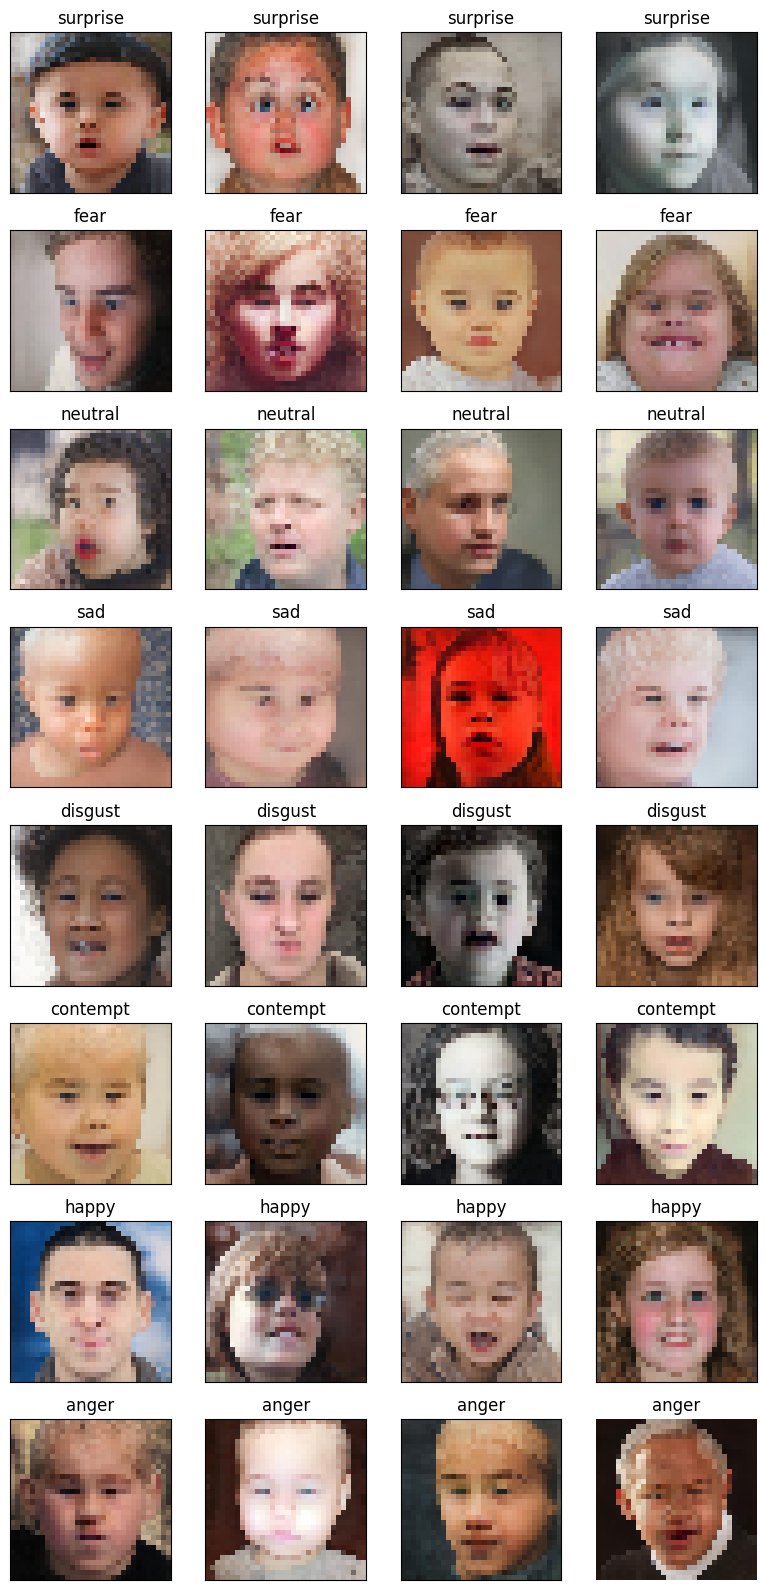

In [ ]:
num_emotions = len(TOP_EMOTIONS)
num_cols = 4
fig, axes = plt.subplots(num_emotions, num_cols, figsize=(num_cols*2, num_emotions*2))

idx = 0
for k in label_to_text:
    sample_indices = np.random.choice(np.where(img_label[:, k] == 1)[0], size=num_cols, replace=False)
    sample_images = img_arr[sample_indices]

    for i, img in enumerate(sample_images):
        ax = axes[idx, i]
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        ax.imshow(img), plt.axis('off')
        ax.set_xticks([])
        ax.set_yticks([])
        ax.set_title(label_to_text[k])

    idx += 1

plt.tight_layout()
plt.show()

In [ ]:
img_arr = img_arr / 255.

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(img_arr, img_label,
                                                    shuffle=True, stratify=img_label,
                                                    train_size=TRAIN_SIZE, random_state=42)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((11718, 32, 32, 3), (2930, 32, 32, 3), (11718, 8), (2930, 8))

In [ ]:
# Define a custom callback for early stopping based on validation accuracy
class CustomEarlyStopping(Callback):
    def __init__(self, monitor='val_accuracy', patience=10, restore_best_weights=True):
        super(CustomEarlyStopping, self).__init__()
        self.monitor = monitor
        self.patience = patience
        self.restore_best_weights = restore_best_weights
        self.best = -np.Inf  # Initialize best to negative infinity
        self.best_epoch = 0
        self.best_weights = None

    def on_epoch_end(self, epoch, logs=None):
        current_val_acc = logs.get(self.monitor)
        if current_val_acc > self.best:
            self.best = current_val_acc
            self.best_epoch = epoch
            self.best_weights = self.model.get_weights()  # Save the best weights
        elif epoch - self.best_epoch >= self.patience:
            print(f"Epoch {epoch}: Early stopping due to no improvement in {self.patience} epochs.")
            self.model.stop_training = True
            if self.restore_best_weights and self.best_weights is not None:
                print(f"Restoring best weights from epoch {self.best_epoch}.")
                self.model.set_weights(self.best_weights)

In [ ]:
# Data augmentation
train_datagen = ImageDataGenerator(
    rotation_range=8,
    width_shift_range=0.08,
    height_shift_range=0.08,
    shear_range=0.1,
    horizontal_flip=True,
)

# Fit the data generator on training data
train_datagen.fit(X_train)

In [ ]:
# https://www.tensorflow.org/guide/keras/transfer_learning#train_the_top_layer

# Load pre-trained DenseNet121 model
base_model = DenseNet121(weights='imagenet', include_top=False, input_shape=INPUT_SHAPE)

# Freeze layers in the pre-trained model
for layer in base_model.layers:
    layer.trainable = False

# Build model on top of pre-trained model
inputs = Input(shape=INPUT_SHAPE)
x = base_model(inputs, training=False)
x = GlobalAveragePooling2D()(x)
x = Dense(256, activation='relu')(x)
x = Dropout(0.2)(x)
x = Dense(128, activation='relu')(x)
predictions = Dense(NUM_CLASSES, activation='softmax')(x)

model = Model(inputs=inputs, outputs=predictions)

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Summary of the model
model.summary()

29084464/29084464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 32, 32, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ densenet121 (Functional)        │ (None, 1, 1, 1024)     │     7,037,504 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 1024)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │       262,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 8)              │         1,032 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,333,832 (27.98 MB)

 Trainable params: 296,328 (1.13 MB)

 Non-trainable params: 7,037,504 (26.85 MB)

In [ ]:
# Define callbacks
lr_scheduler = ReduceLROnPlateau(
    monitor='val_accuracy',
    min_delta=0.0001,
    factor=0.1,
    patience=4,
    min_lr=1e-7,
    verbose=1,
)

early_stopping = EarlyStopping(
    monitor='val_accuracy',
    min_delta=0.0005,
    patience=15,
    verbose=1,
    restore_best_weights=True,
)

In [ ]:
custom_early_stopping = CustomEarlyStopping(patience=15)

# Train the top layer
history_top_layer = model.fit(
    train_datagen.flow(X_train, y_train, batch_size=BATCH_SIZE),
    validation_data=(X_test, y_test),
    steps_per_epoch=int(len(X_train) / BATCH_SIZE),
    epochs=EPOCHS,
    callbacks=[lr_scheduler, custom_early_stopping],
)

Epoch 1/100


/opt/conda/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


  3/183 ━━━━━━━━━━━━━━━━━━━━ 6s 35ms/step - accuracy: 0.1927 - loss: 2.4562    

I0000 00:00:1712140480.410183     117 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.
W0000 00:00:1712140480.469717     117 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


 53/183 ━━━━━━━━━━━━━━━━━━━━ 35s 275ms/step - accuracy: 0.1717 - loss: 2.2059

W0000 00:00:1712140494.615040     120 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


181/183 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step - accuracy: 0.1893 - loss: 2.0934

W0000 00:00:1712140513.906515     118 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1712140524.069182     120 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


183/183 ━━━━━━━━━━━━━━━━━━━━ 72s 241ms/step - accuracy: 0.1896 - loss: 2.0921 - val_accuracy: 0.2386 - val_loss: 1.9115 - learning_rate: 0.0010
Epoch 2/100
  1/183 ━━━━━━━━━━━━━━━━━━━━ 3s 20ms/step - accuracy: 0.2344 - loss: 1.9348

/opt/conda/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


183/183 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.2344 - loss: 1.9348 - val_accuracy: 0.2396 - val_loss: 1.9103 - learning_rate: 0.0010
Epoch 3/100
183/183 ━━━━━━━━━━━━━━━━━━━━ 9s 48ms/step - accuracy: 0.2391 - loss: 1.9176 - val_accuracy: 0.2427 - val_loss: 1.9018 - learning_rate: 0.0010
Epoch 4/100
183/183 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.2656 - loss: 1.8399 - val_accuracy: 0.2447 - val_loss: 1.9010 - learning_rate: 0.0010
Epoch 5/100
183/183 ━━━━━━━━━━━━━━━━━━━━ 9s 48ms/step - accuracy: 0.2457 - loss: 1.8960 - val_accuracy: 0.2580 - val_loss: 1.8678 - learning_rate: 0.0010
Epoch 6/100
183/183 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.3281 - loss: 1.8878 - val_accuracy: 0.2519 - val_loss: 1.8715 - learning_rate: 0.0010
Epoch 7/100
183/183 ━━━━━━━━━━━━━━━━━━━━ 9s 47ms/step - accuracy: 0.2641 - loss: 1.8658 - val_accuracy: 0.2659 - val_loss: 1.8566 - learning_rate: 0.0010
Epoch 8/100
183/183 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.2188 - loss: 1.8790 - va

In [ ]:
# Create history dataframe for the top layer training
history_top_layer_df = pd.DataFrame(history_top_layer.history)
history_top_layer_df

,accuracy,loss,val_accuracy,val_loss,learning_rate
0,0.206882,2.011580,0.238567,1.911459,1.000000e-03
1,0.234375,1.934811,0.239590,1.910299,1.000000e-03
2,0.236829,1.919336,0.242662,1.901774,1.000000e-03
3,0.265625,1.839872,0.244710,1.901040,1.000000e-03
4,0.254162,1.888061,0.258020,1.867836,1.000000e-03
5,0.328125,1.887833,0.251877,1.871516,1.000000e-03
6,0.264373,1.870701,0.265870,1.856623,1.000000e-03
7,0.218750,1.879029,0.266894,1.853798,1.000000e-03
8,0.275444,1.850870,0.273720,1.855834,1.000000e-03
9,0.333333,1.966508,0.270307,1.862846,1.000000e-03


In [ ]:
# Fine-tuning the entire model
for layer in base_model.layers:
    layer.trainable = True

# Compile the model again
model.compile(optimizer=optimizers.Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])

# Summary of the model after fine-tuning
model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 32, 32, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ densenet121 (Functional)        │ (None, 1, 1, 1024)     │     7,037,504 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 1024)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │       262,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 8)              │         1,032 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,333,832 (27.98 MB)

 Trainable params: 7,250,184 (27.66 MB)

 Non-trainable params: 83,648 (326.75 KB)

In [ ]:
# Train the entire model end-to-end with a low learning rate
history_fine_tuning = model.fit(
    train_datagen.flow(X_train, y_train, batch_size=BATCH_SIZE),
    validation_data=(X_test, y_test),
    steps_per_epoch=int(len(X_train) / BATCH_SIZE),
    epochs=EPOCHS,
    callbacks=[lr_scheduler, custom_early_stopping],
)

Epoch 1/100


/opt/conda/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


  3/183 ━━━━━━━━━━━━━━━━━━━━ 11s 65ms/step - accuracy: 0.1979 - loss: 2.0846  

W0000 00:00:1712140862.927242     118 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


173/183 ━━━━━━━━━━━━━━━━━━━━ 4s 457ms/step - accuracy: 0.2062 - loss: 2.0439

W0000 00:00:1712140941.412007     117 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


182/183 ━━━━━━━━━━━━━━━━━━━━ 0s 436ms/step - accuracy: 0.2070 - loss: 2.0407

W0000 00:00:1712140950.266454     119 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


183/183 ━━━━━━━━━━━━━━━━━━━━ 223s 509ms/step - accuracy: 0.2071 - loss: 2.0400 - val_accuracy: 0.2638 - val_loss: 1.8775 - learning_rate: 1.0000e-04
Epoch 2/100
  1/183 ━━━━━━━━━━━━━━━━━━━━ 10s 60ms/step - accuracy: 0.2656 - loss: 1.8621

W0000 00:00:1712140955.620995     120 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
/opt/conda/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


183/183 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.2656 - loss: 1.8621 - val_accuracy: 0.2662 - val_loss: 1.8759 - learning_rate: 1.0000e-04
Epoch 3/100
183/183 ━━━━━━━━━━━━━━━━━━━━ 10s 51ms/step - accuracy: 0.2731 - loss: 1.8422 - val_accuracy: 0.2867 - val_loss: 1.7821 - learning_rate: 1.0000e-04
Epoch 4/100
183/183 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.3438 - loss: 1.7732 - val_accuracy: 0.2833 - val_loss: 1.7832 - learning_rate: 1.0000e-04
Epoch 5/100
183/183 ━━━━━━━━━━━━━━━━━━━━ 10s 56ms/step - accuracy: 0.3063 - loss: 1.7491 - val_accuracy: 0.3126 - val_loss: 1.7538 - learning_rate: 1.0000e-04
Epoch 6/100
183/183 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.4375 - loss: 1.6797 - val_accuracy: 0.3123 - val_loss: 1.7551 - learning_rate: 1.0000e-04
Epoch 7/100
183/183 ━━━━━━━━━━━━━━━━━━━━ 10s 53ms/step - accuracy: 0.3488 - loss: 1.6642 - val_accuracy: 0.3430 - val_loss: 1.6896 - learning_rate: 1.0000e-04
Epoch 8/100
183/183 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy:

In [ ]:
# Create history dataframe for fine-tuning
history_fine_tuning_df = pd.DataFrame(history_fine_tuning.history)
history_fine_tuning_df

,accuracy,loss,val_accuracy,val_loss,learning_rate
0,0.222327,1.977408,0.263823,1.877451,1.000000e-04
1,0.265625,1.862133,0.266212,1.875882,1.000000e-04
2,0.276300,1.824148,0.286689,1.782069,1.000000e-04
3,0.343750,1.773231,0.283276,1.783221,1.000000e-04
4,0.312511,1.731280,0.312628,1.753842,1.000000e-04
...,...,...,...,...,...
81,0.828125,0.439345,0.504096,1.750544,1.000000e-07
82,0.810966,0.546438,0.503413,1.749774,1.000000e-07
83,0.828125,0.456575,0.502730,1.750059,1.000000e-07
84,0.813369,0.547056,0.503413,1.746612,1.000000e-07


/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  

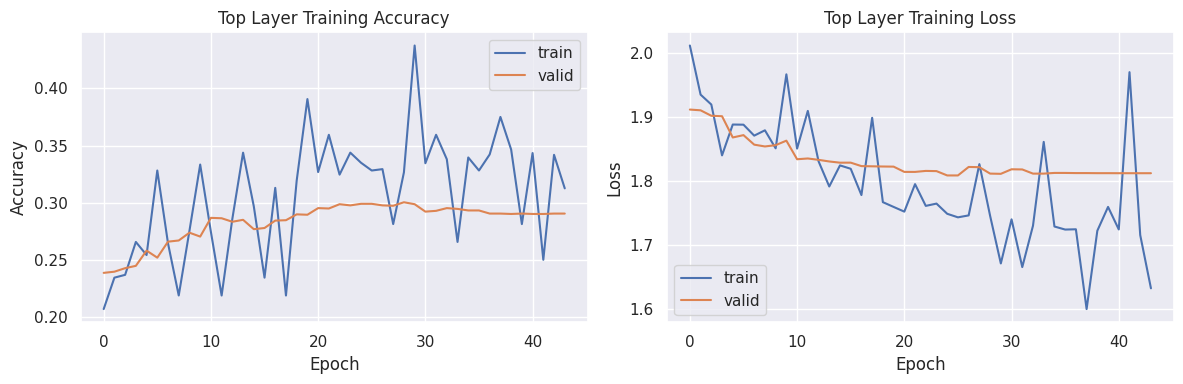

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  

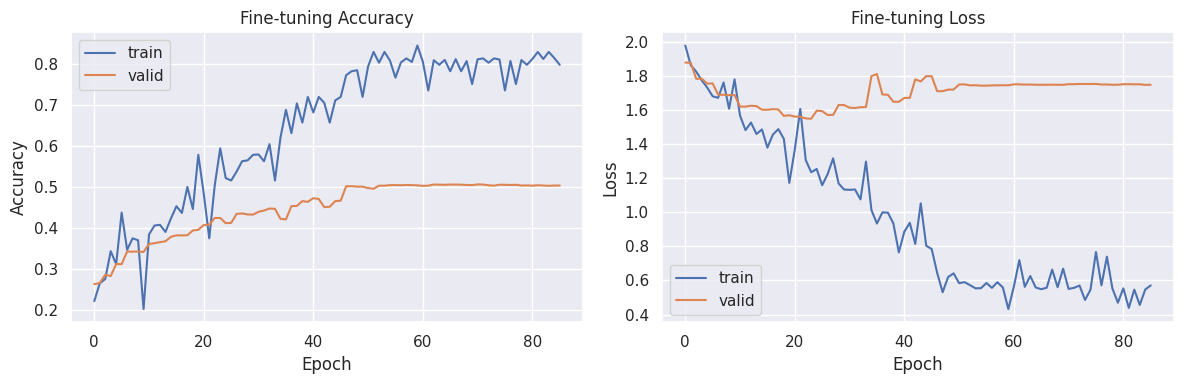

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# Visualize training history for the top layer training
sns.set()
fig = plt.figure(figsize=(12, 4))

ax = plt.subplot(1, 2, 1)
sns.lineplot(x=history_top_layer_df.index, y=history_top_layer_df['accuracy'], label='train')
sns.lineplot(x=history_top_layer_df.index, y=history_top_layer_df['val_accuracy'], label='valid')
plt.title('Top Layer Training Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.tight_layout()

ax = plt.subplot(1, 2, 2)
sns.lineplot(x=history_top_layer_df.index, y=history_top_layer_df['loss'], label='train')
sns.lineplot(x=history_top_layer_df.index, y=history_top_layer_df['val_loss'], label='valid')
plt.title('Top Layer Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.tight_layout()

plt.show()

# Visualize training history for fine-tuning
sns.set()
fig = plt.figure(figsize=(12, 4))

ax = plt.subplot(1, 2, 1)
sns.lineplot(x=history_fine_tuning_df.index, y=history_fine_tuning_df['accuracy'], label='train')
sns.lineplot(x=history_fine_tuning_df.index, y=history_fine_tuning_df['val_accuracy'], label='valid')
plt.title('Fine-tuning Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.tight_layout()

ax = plt.subplot(1, 2, 2)
sns.lineplot(x=history_fine_tuning_df.index, y=history_fine_tuning_df['loss'], label='train')
sns.lineplot(x=history_fine_tuning_df.index, y=history_fine_tuning_df['val_loss'], label='valid')
plt.title('Fine-tuning Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.tight_layout()

plt.show()


367/367 - 8s - 23ms/step - accuracy: 0.8696 - loss: 0.3845


W0000 00:00:1712141428.154563     118 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update



train Accuracy: 0.8696023225784302
92/92 - 1s - 11ms/step - accuracy: 0.5061 - loss: 1.7506

Test Accuracy: 0.50614333152771
16/92 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step

W0000 00:00:1712141438.129397     118 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


92/92 ━━━━━━━━━━━━━━━━━━━━ 18s 103ms/step


W0000 00:00:1712141447.503874     120 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update



Classification Report:
               precision    recall  f1-score   support

       anger       0.43      0.39      0.41       370
    contempt       0.46      0.51      0.48       368
     disgust       0.68      0.68      0.68       376
        fear       0.41      0.37      0.39       364
       happy       0.41      0.44      0.42       348
     neutral       0.49      0.53      0.51       367
         sad       0.77      0.72      0.75       373
    surprise       0.40      0.40      0.40       364

    accuracy                           0.51      2930
   macro avg       0.51      0.50      0.50      2930
weighted avg       0.51      0.51      0.51      2930



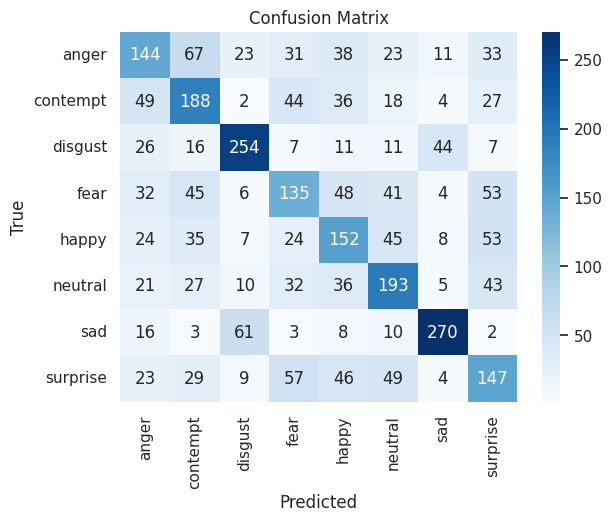

In [ ]:
# Evaluate the model
train_loss, train_acc = model.evaluate(X_train, y_train, verbose=2)
print(f"\ntrain Accuracy: {train_acc}")

# Evaluate the model
test_loss, test_acc = model.evaluate(X_test, y_test, verbose=2)
print(f"\nTest Accuracy: {test_acc}")

# Predictions
predictions = model.predict(X_test)
predicted_labels = np.argmax(predictions, axis=1)
true_labels = np.argmax(y_test, axis=1)

# Classification Report
print("\nClassification Report:\n", classification_report(true_labels, predicted_labels, target_names=TOP_EMOTIONS))

# Confusion Matrix
cm = confusion_matrix(true_labels, predicted_labels)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=TOP_EMOTIONS, yticklabels=TOP_EMOTIONS)
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

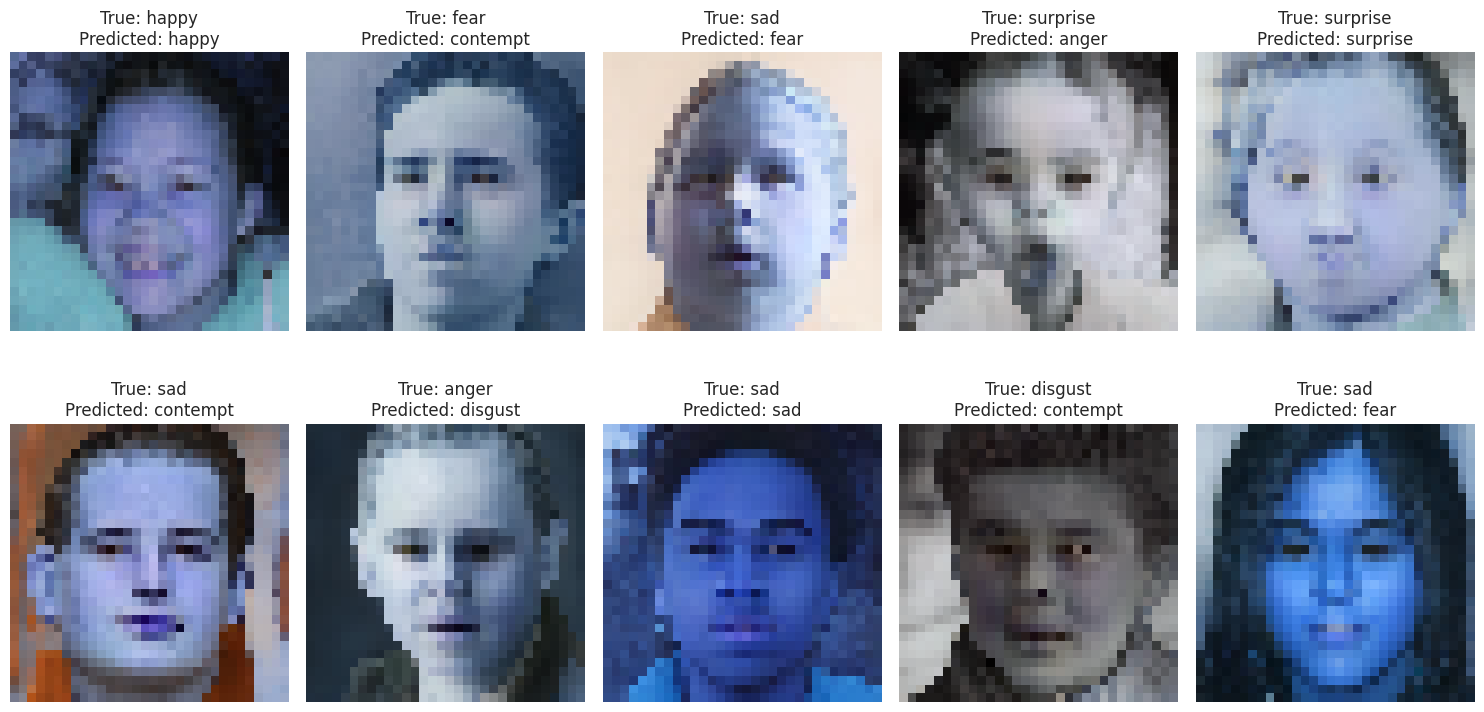

In [ ]:
import random

# Visualize some predictions
num_images_to_visualize = 10
random_indices = np.random.choice(len(X_test), size=num_images_to_visualize, replace=False)

plt.figure(figsize=(15, 8))
for i, idx in enumerate(random_indices):
    plt.subplot(2, 5, i + 1)
    plt.imshow(X_test[idx])
    plt.title(f"True: {label_to_text[true_labels[idx]]}\nPredicted: {label_to_text[predicted_labels[idx]]}")
    plt.axis('off')
plt.tight_layout()
plt.show()